In [140]:
import pybedtools
import pyranges

gencode = pyranges.read_gtf("../data/gencode.v40.basic.annotation.gtf")
gm12878_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF338RIC.bed").to_dataframe()
h1esc_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF323HNB.bed").to_dataframe()
hffc6_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF393FSC.bed").to_dataframe()

active_gene_states = ['TssA', 'TssAFlnk', 'TxFlnk', 'Tx', 'TxWk', 'EnhG', 'EnhG1', 'EnhG2', 'Enh', 'EnhA1', 'EnhA2']

In [141]:
# cut .xx postfix from gene_id
# gencode['gene_id'] = gencode['gene_id'].str.split('.')[0]
genes_from_gencode = (
    gencode
    [(gencode['Feature'] == 'gene') & (gencode['gene_type'] == 'protein_coding')]
    [['Chromosome', 'Start', 'End', 'gene_id']]
)

genes_from_gencode['gene_id'] = genes_from_gencode['gene_id'].str.split('.').str[0]

genes_from_gencode

,Chromosome,Start,End,gene_id
54,chr1,65418,71585,ENSG00000186092
176,chr1,450739,451678,ENSG00000284733
241,chr1,685715,686654,ENSG00000284662
454,chr1,923922,944575,ENSG00000187634
554,chr1,944202,959309,ENSG00000188976
...,...,...,...,...
1926870,chrM,10469,10766,ENSG00000212907
1926877,chrM,10759,12137,ENSG00000198886
1926891,chrM,12336,14148,ENSG00000198786
1926897,chrM,14148,14673,ENSG00000198695


In [142]:
import pandas as pd

distances_with_links_exp4 = pd.read_parquet("./links/experiment_4/distances_with_links.parquet").rename({"dist_avg_dist": "avg_dist"}, axis=1)
distances_with_links_exp5 = pd.read_parquet("./links/experiment_5/distances_with_links.parquet").rename({"dist_avg_dist": "avg_dist"}, axis=1)
distances_with_links = pd.concat([distances_with_links_exp4, distances_with_links_exp5], ignore_index=True)

gm12878_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'GM12878']
hffc6_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'HFFC6']
h1esc_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'H1ESC']

In [143]:
distance_cutoff = {
    'H1ESC_Nean': 1.5819487888988626,
    'H1ESC_Deni': 1.5940225214185284,
    'HFFC6_Nean': 1.4982763183612486,
    'HFFC6_Deni': 1.7777412978743463,
    'WTC11_Nean': 0.49185075802354294,
    'WTC11_Deni': 0.49946283771094635,
    'GM12878_Nean': 1.3194976373807719,
    'GM12878_Deni': 1.2678860440889042
}

gm12878_neanderthal_df_ref = gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref["avg_dist"] > distance_cutoff["GM12878_Nean"]]
hffc6_neanderthal_df_ref = hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref["avg_dist"] > distance_cutoff["HFFC6_Nean"]]
h1esc_neanderthal_df_ref = h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref["avg_dist"] > distance_cutoff["H1ESC_Nean"]]

In [144]:
# Attach gene coordinates to the distances, split enh_id (chrX:12345-67890) into chromosome, start, end
gm12878_neanderthal_df_ref = (
    gm12878_neanderthal_df_ref
    .merge(genes_from_gencode, left_on='gene_id', right_on='gene_id', how='left', suffixes=('', '_gene'))
    .rename({'Chromosome': 'gene_chromosome', 'Start': 'gene_start', 'End': 'gene_end'}, axis=1)
)
gm12878_neanderthal_df_ref[['enh_chromosome', 'enh_start', 'enh_end']] = gm12878_neanderthal_df_ref['enh_id'].str.split(':|-', expand=True)
gm12878_neanderthal_df_ref['enh_start'] = gm12878_neanderthal_df_ref['enh_start'].astype(int)
gm12878_neanderthal_df_ref['enh_end'] = gm12878_neanderthal_df_ref['enh_end'].astype(int)

hffc6_neanderthal_df_ref = (
    hffc6_neanderthal_df_ref
    .merge(genes_from_gencode, left_on='gene_id', right_on='gene_id', how='left', suffixes=('', '_gene'))
    .rename({'Chromosome': 'gene_chromosome', 'Start': 'gene_start', 'End': 'gene_end'}, axis=1)
)
hffc6_neanderthal_df_ref[['enh_chromosome', 'enh_start', 'enh_end']] = hffc6_neanderthal_df_ref['enh_id'].str.split(':|-', expand=True)
hffc6_neanderthal_df_ref['enh_start'] = hffc6_neanderthal_df_ref['enh_start'].astype(int)
hffc6_neanderthal_df_ref['enh_end'] = hffc6_neanderthal_df_ref['enh_end'].astype(int)

h1esc_neanderthal_df_ref = (
    h1esc_neanderthal_df_ref
    .merge(genes_from_gencode, left_on='gene_id', right_on='gene_id', how='left', suffixes=('', '_gene'))
    .rename({'Chromosome': 'gene_chromosome', 'Start': 'gene_start', 'End': 'gene_end'}, axis=1)
)
h1esc_neanderthal_df_ref[['enh_chromosome', 'enh_start', 'enh_end']] = h1esc_neanderthal_df_ref['enh_id'].str.split(':|-', expand=True)
h1esc_neanderthal_df_ref['enh_start'] = h1esc_neanderthal_df_ref['enh_start'].astype(int)
h1esc_neanderthal_df_ref['enh_end'] = h1esc_neanderthal_df_ref['enh_end'].astype(int)

In [145]:
def mark_active_regions(df, chromatin_states_df, active_gene_states):
    # Create PyRanges for active regions
    active_regions_pr = pyranges.PyRanges(
        {
            "Chromosome": chromatin_states_df['chrom'][chromatin_states_df['name'].isin(active_gene_states)],
            "Start": chromatin_states_df['start'][chromatin_states_df['name'].isin(active_gene_states)],
            "End": chromatin_states_df['end'][chromatin_states_df['name'].isin(active_gene_states)]
        }
    )

    # Create PyRanges objects for genes and enhancers with index as identifier
    genes_pr = pyranges.PyRanges(
        {
            "Chromosome": df['gene_chromosome'],
            "Start": df['gene_start'],
            "End": df['gene_end'],
            "row_id": df.index
        }
    )

    enhancers_pr = pyranges.PyRanges(
        {
            "Chromosome": df['enh_chromosome'],
            "Start": df['enh_start'],
            "End": df['enh_end'],
            "row_id": df.index
        }
    )

    # Find genes and enhancers that overlap with active regions
    active_genes = genes_pr.intersect(active_regions_pr)
    active_enhancers = enhancers_pr.intersect(active_regions_pr)

    # Get sets of row IDs where genes and enhancers are active
    active_gene_rows = set(active_genes['row_id']) if not active_genes.empty else set()
    active_enhancer_rows = set(active_enhancers['row_id']) if not active_enhancers.empty else set()

    # Find rows where both gene and enhancer are active (intersection of sets)
    active_rows = active_gene_rows.intersection(active_enhancer_rows)

    # Create a copy of the input dataframe with the is_active column added
    result_df = df.copy()
    result_df['is_active'] = result_df.index.isin(active_rows)

    return result_df

gm12878_neanderthal_df_ref = mark_active_regions(gm12878_neanderthal_df_ref, gm12878_chromatin_states, active_gene_states)
gm12878_neanderthal_df_ref = gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref['is_active']].drop(columns=['is_active'])

hffc6_neanderthal_df_ref = mark_active_regions(hffc6_neanderthal_df_ref, hffc6_chromatin_states, active_gene_states)
hffc6_neanderthal_df_ref = hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref['is_active']].drop(columns=['is_active'])

h1esc_neanderthal_df_ref = mark_active_regions(h1esc_neanderthal_df_ref, h1esc_chromatin_states, active_gene_states)
h1esc_neanderthal_df_ref = h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref['is_active']].drop(columns=['is_active'])

In [146]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

with open("../data/rnaseq/gm12878_read_count.txt", "r") as f:
    # Skip the first line
    f.readline()
    gm12878_counts_df = pd.read_csv(f, index_col=0, sep="\t")


with open("../data/rnaseq/h1esc_read_count.txt", "r") as f:
    # Skip the first line
    f.readline()
    h1esc_counts_df = pd.read_csv(f, index_col=0, sep="\t")

with open("../data/rnaseq/hffc6_read_count.txt", "r") as f:
    # Skip the first line
    f.readline()
    hffc6_counts_df = pd.read_csv(f, index_col=0, sep="\t")

gm12878_counts_df = gm12878_counts_df[['ENCFF800HIP.filtered.bam', 'ENCFF991KKX.filtered.bam']].T
h1esc_counts_df = h1esc_counts_df[['ENCFF675NTU.filtered.bam', 'ENCFF379NOY.filtered.bam']].T
hffc6_counts_df = hffc6_counts_df[['ENCFF307KUI.filtered.bam', 'ENCFF294BSI.filtered.bam', 'ENCFF937TEI.filtered.bam']].T

def compute_deseq_stats_for_2_celllines(cellline1_counts_df, cellline2_counts_df, cellline1_name="CellLine1", cellline2_name="CellLine2"):
    cl1_vs_cl2_counts_df = pd.concat(
        [cellline1_counts_df, cellline2_counts_df]
    )

    cl1_vs_cl2_metadata_df = pd.DataFrame(
        {
            "condition": [cellline1_name] * cellline1_counts_df.shape[0] + [cellline2_name] * cellline2_counts_df.shape[0]
        },
        index=cl1_vs_cl2_counts_df.index,
    )

    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        counts=cl1_vs_cl2_counts_df,
        metadata=cl1_vs_cl2_metadata_df,
        design="~condition",
        refit_cooks=True,
        inference=inference,
    )

    dds.deseq2()
    stats = DeseqStats(dds, contrast=["condition", cellline1_name, cellline2_name])
    stats.summary()

    results_df = stats.results_df.dropna()
    results_df['symbol'] = results_df.index
    return results_df

gm12878_vs_h1esc_results_df = compute_deseq_stats_for_2_celllines(
    gm12878_counts_df,
    h1esc_counts_df,
    cellline1_name="GM12878",
    cellline2_name="H1ESC"
)

h1esc_vs_hffc6_results_df = compute_deseq_stats_for_2_celllines(
    h1esc_counts_df,
    hffc6_counts_df,
    cellline1_name="H1ESC",
    cellline2_name="HFFC6"
)

hffc6_vs_gm12878_results_df = compute_deseq_stats_for_2_celllines(
    hffc6_counts_df,
    gm12878_counts_df,
    cellline1_name="HFFC6",
    cellline2_name="GM12878"
)

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.05 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pydeseq2/dds.py:542: UserWarning:

As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.

Fitting MAP dispersions...
... done in 1.46 seconds.

Fitting LFCs...
... done in 1.48 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.70 seconds.

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_14059/3877865056.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Log2 fold change & Wald test p-value: condition GM12878 vs H1ESC
                       baseMean  log2FoldChange     lfcSE      stat  \
Geneid                                                                
ENSG00000223972.5      0.000000             NaN       NaN       NaN   
ENSG00000227232.5      0.000000             NaN       NaN       NaN   
ENSG00000278267.1      2.248036       -0.506469  1.823320 -0.277773   
ENSG00000243485.5      0.000000             NaN       NaN       NaN   
ENSG00000284332.1      0.000000             NaN       NaN       NaN   
...                         ...             ...       ...       ...   
ENSG00000198695.2   2048.736260       -0.437514  0.086208 -5.075096   
ENSG00000210194.1     23.651924        0.576258  0.577638  0.997612   
ENSG00000198727.2  38697.120986        0.371529  0.058147  6.389494   
ENSG00000210195.2     89.769900        1.306326  0.306061  4.268188   
ENSG00000210196.2     98.976794        0.069780  0.282614  0.246908   

           

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.27 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pydeseq2/dds.py:542: UserWarning:

As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.

Fitting MAP dispersions...
... done in 1.65 seconds.

Fitting LFCs...
... done in 1.34 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.38 seconds.

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_14059/3877865056.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Log2 fold change & Wald test p-value: condition H1ESC vs HFFC6
                       baseMean  log2FoldChange     lfcSE      stat  \
Geneid                                                                
ENSG00000223972.5      0.000000             NaN       NaN       NaN   
ENSG00000227232.5      4.548690       -5.383865  2.586318 -2.081671   
ENSG00000278267.1      1.372396        1.891656  2.006040  0.942980   
ENSG00000243485.5      0.000000             NaN       NaN       NaN   
ENSG00000284332.1      0.000000             NaN       NaN       NaN   
...                         ...             ...       ...       ...   
ENSG00000198695.2   1669.869168        0.718368  0.150894  4.760729   
ENSG00000210194.1     12.167266        1.037633  0.679102  1.527948   
ENSG00000198727.2  25784.760948        0.497953  0.193864  2.568560   
ENSG00000210195.2    106.491115       -1.604338  0.280161 -5.726478   
ENSG00000210196.2     64.532522        0.902914  0.328352  2.749838   

             

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.30 seconds.

Fitting dispersion trend curve...
... done in 0.34 seconds.

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pydeseq2/dds.py:542: UserWarning:

As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.

Fitting MAP dispersions...
... done in 1.52 seconds.

Fitting LFCs...
... done in 1.37 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition HFFC6 vs GM12878
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                          
ENSG00000223972.5      0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232.5      4.876008        5.631698  2.581318  2.181715  0.029131   
ENSG00000278267.1      1.138906       -1.341493  2.194531 -0.611289  0.541008   
ENSG00000243485.5      0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332.1      0.000000             NaN       NaN       NaN       NaN   
...                         ...             ...       ...       ...       ...   
ENSG00000198695.2   1520.630326       -0.231177  0.157710 -1.465835  0.142693   
ENSG00000210194.1     16.391290       -1.564962  0.603404 -2.593556  0.009499   
ENSG00000198727.2  30956.220844       -0.819239  0.191453 -4.279060  0.000019   
ENSG00000210195.2    142.558092        0.348

... done in 1.36 seconds.

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_14059/3877865056.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [147]:

gm12878_gene_to_closest_avg_enhancer_all = (
    gm12878_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)
gm12878_gene_to_closest_avg_enhancer_all['has_link'] = (
    gm12878_gene_to_closest_avg_enhancer_all.index
    .isin(gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

hffc6_gene_to_closest_avg_enhancer_all = (
    hffc6_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)

hffc6_gene_to_closest_avg_enhancer_all['has_link'] = (
    hffc6_gene_to_closest_avg_enhancer_all.index
    .isin(hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

h1esc_gene_to_closest_avg_enhancer_all = (
    h1esc_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)

h1esc_gene_to_closest_avg_enhancer_all['has_link'] = (
    h1esc_gene_to_closest_avg_enhancer_all.index
    .isin(h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

for df, name in [
    (gm12878_gene_to_closest_avg_enhancer_all, 'gm12878'),
    (hffc6_gene_to_closest_avg_enhancer_all, 'hffc6'),
    (h1esc_gene_to_closest_avg_enhancer_all, 'h1esc'),
]:
    q1 = df['min_dist'].quantile(0.33)
    q3 = df['min_dist'].quantile(0.66)
    def label_quartile(x):
        if x <= q1:
            return 'small'
        elif x <= q3:
            return 'mid'
        else:
            return 'large'
    df['quartile_cat'] = df['min_dist'].apply(label_quartile)

In [148]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np
import joypy
from matplotlib import cm

def plot_distance_vs_expression_correlation(
    cell1_distances_df,
    cell2_distances_df,
    deseq_results_df,
    cell1_name,
    cell2_name,
    figsize=(20, 20),
    plot_path=None,
    color_map=cm.viridis,
    font_size=18,
    log2fc_threshold=2,
    padj_threshold=0.05
):
    deseq_results_df = deseq_results_df.copy()

    # Cut .xx from gene index of
    deseq_results_df.index = deseq_results_df.index.str.split('.').str[0]

    deseq_results_df = deseq_results_df[
        (deseq_results_df["padj"] < padj_threshold)
        & (deseq_results_df["log2FoldChange"].abs() > log2fc_threshold)
    ]

    # Normalize all distances against average distance
    cell1_distances_df = cell1_distances_df.copy()
    cell1_distances_df['norm_min_dist'] = (
        (cell1_distances_df['min_dist'] - cell1_distances_df['min_dist'].min()) / (cell1_distances_df['min_dist'].max() - cell1_distances_df['min_dist'].min())
    )

    cell2_distances_df = cell2_distances_df.copy()
    cell2_distances_df['norm_min_dist'] = (
        (cell2_distances_df['min_dist'] - cell2_distances_df['min_dist'].min()) / (cell2_distances_df['min_dist'].max() - cell2_distances_df['min_dist'].min())
    )

    # Join the two distance dataframes
    combined_df = cell1_distances_df.merge(
        cell2_distances_df,
        left_index=True,
        right_index=True,
        how="inner",
        suffixes=(f"_{cell1_name}", f"_{cell2_name}")
    )

    # Calculate min_dist change (log ratio for better scaling)
    combined_df["log_dist_ratio"] = np.log2(combined_df[f"min_dist_{cell1_name}"] / combined_df[f"min_dist_{cell2_name}"])
    combined_df["dist_diff"] = combined_df[f"min_dist_{cell1_name}"] - combined_df[f"min_dist_{cell2_name}"]

    combined_df["norm_dist_diff"] = combined_df[f"norm_min_dist_{cell1_name}"] - combined_df[f"norm_min_dist_{cell2_name}"]
    combined_df["log_norm_dist_ratio"] = np.log2(combined_df[f"norm_min_dist_{cell1_name}"] / combined_df[f"norm_min_dist_{cell2_name}"])

    # Define link change categories
    def get_link_change(row):
        if row[f"has_link_{cell1_name}"] and not row[f"has_link_{cell2_name}"]:
            return f"Only {cell1_name}"
        elif not row[f"has_link_{cell1_name}"] and row[f"has_link_{cell2_name}"]:
            return f"Only {cell2_name}"
        elif row[f"has_link_{cell1_name}"] and row[f"has_link_{cell2_name}"]:
            return "Both"
        else:
            return "Neither"

    combined_df["link_status"] = combined_df.apply(get_link_change, axis=1)

    # Define quartile change categories
    def get_quartile_change(row):
        q1 = row[f"quartile_cat_{cell1_name}"]
        q2 = row[f"quartile_cat_{cell2_name}"]

        if q1 == q2:
            return "No change"

        categories = ["small", "mid", "large"]
        idx1 = categories.index(q1)
        idx2 = categories.index(q2)

        if idx1 > idx2:
            return f"Decreased ({q1} to {q2})"
        else:
            return f"Increased ({q1} to {q2})"

    combined_df["quartile_change"] = combined_df.apply(get_quartile_change, axis=1)

    # Merge with DESeq2 results
    merged_df = combined_df.merge(
        deseq_results_df[["log2FoldChange", "padj"]],
        left_index=True,
        right_index=True,
        how="inner"
    )

    merged_df_for_correlation = merged_df.copy()
    # Filter out insignificant changes in quartile change
    merged_df_for_correlation = merged_df_for_correlation[
        ~merged_df_for_correlation["quartile_change"].isin([
            "No change",
            "Increased (small to mid)",
            "Increased (mid to large)",
            "Decreased (large to mid)",
            "Decreased (mid to small)",
        ])
    ]

    merged_df_for_plotting = merged_df.copy()
    merged_df_for_plotting = merged_df_for_plotting[
        ~merged_df_for_plotting["quartile_change"].isin([
            "Increased (small to mid)",
            "Increased (mid to large)",
            "Decreased (large to mid)",
            "Decreased (mid to small)",
        ])
    ]

    # Calculate and display correlation
    # pearson_r, pearson_p = pearsonr(merged_df_for_correlation["log_dist_ratio"], merged_df_for_correlation["log2FoldChange"], alternative='two-sided') - data is not normally distributed
    spearman_r, spearman_p = spearmanr(merged_df_for_correlation["log_dist_ratio"], merged_df_for_correlation["log2FoldChange"], alternative='two-sided')

    # Plot: Log2 fold change by quartile change
    # Define order for visualization
    quartile_order = [
        "Increased (small to large)",
        # "Increased (mid to large)",
        # "Increased (small to mid)",
        "No change",
        "Decreased (large to small)",
        # "Decreased (mid to small)",
        # "Decreased (large to mid)"
    ]

    # Filter out empty categories
    available_categories = merged_df_for_plotting["quartile_change"].unique()
    plot_order = [cat for cat in quartile_order if cat in available_categories]

    # Create plot data dictionary
    plot_data = {}
    for category in plot_order:
        subset = merged_df_for_plotting[merged_df_for_plotting["quartile_change"] == category]
        if len(subset) >= 3:  # Minimum data points for KDE
            plot_data[category] = subset["log2FoldChange"]

    # Create figure
    fig, axes = joypy.joyplot(
        plot_data,
        figsize=figsize,
        colormap=color_map,
        overlap=0.7,
        linewidth=1,
        alpha=0.8,
        grid="y",
        legend=False,
        title=f"Expression Change by Distance Change for {cell1_name} vs {cell2_name}\n" +
              # f"Pearson r: {pearson_r:.3f} (p: {pearson_p:.2e}) | " +
              f"Spearman r: {spearman_r:.3f} (p: {spearman_p:.2e})",
        range_style='own',

    )

    # print(f'Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.2e}')
    print(f'Spearman r: {spearman_r:.3f}, p-value: {spearman_p:.2e}')

    # Customize plot
    plt.xlabel("Log2 Fold Change", fontsize=font_size)

    # Add gray vertical lines at log2FC = 0
    for ax in axes[:-1]:  # Skip the last ax which is just for the x-axis
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    # Add vertical lines at log2FC = -1 and log2FC = 1 to each subplot
    for ax in axes[:-1]:  # Skip the last ax which is just for the x-axis
        ax.axvline(x=-log2fc_threshold, color='gray', linestyle='--', alpha=0.7, linewidth=1)
        ax.axvline(x=log2fc_threshold, color='gray', linestyle='--', alpha=0.7, linewidth=1)

    title = axes[-1].get_title()
    axes[-1].set_title(title, fontsize=font_size)
    for ax in axes:
        label = ax.get_yticklabels()
        ax.set_yticklabels(label, fontsize=font_size)
    # # Add red vertical link at mean of log2FoldChange for each quartile change
    # for ax, category in zip(axes[:-1], plot_order):
    #     if category in plot_data:
    #         mean_value = plot_data[category].mean()
    #         ax.axvline(x=mean_value, color='red', linestyle='-', alpha=0.7, linewidth=1)

    # Add legend with better position
    handles = []
    for i, label in enumerate(plot_data.keys()):
        color = color_map(i / len(plot_data))
        handles.append(plt.Rectangle((0,0), 1, 1, color=color, alpha=0.7))

    # Add threshold lines to legend
    handles.append(plt.Line2D([0], [0], color='gray', linestyle='--', alpha=0.7))
    legend_labels = list(plot_data.keys()) + [f'Significance threshold (|log2FC| > {log2fc_threshold})']

    # handles.append(plt.Line2D([0], [0], color='red', linestyle='-', alpha=0.7))
    # legend_labels.append('Mean log2FC for each quartile change')

    plt.figlegend(
        handles, legend_labels,
        loc="upper left",
        bbox_to_anchor=(0.99, 0.98),
        title="Quartile Change",
        fontsize=font_size,
    )

    if plot_path:
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    else:
        plt.tight_layout()

    return fig, merged_df

Spearman r: -0.507, p-value: 8.86e-11


/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log2

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_14059/1618299180.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



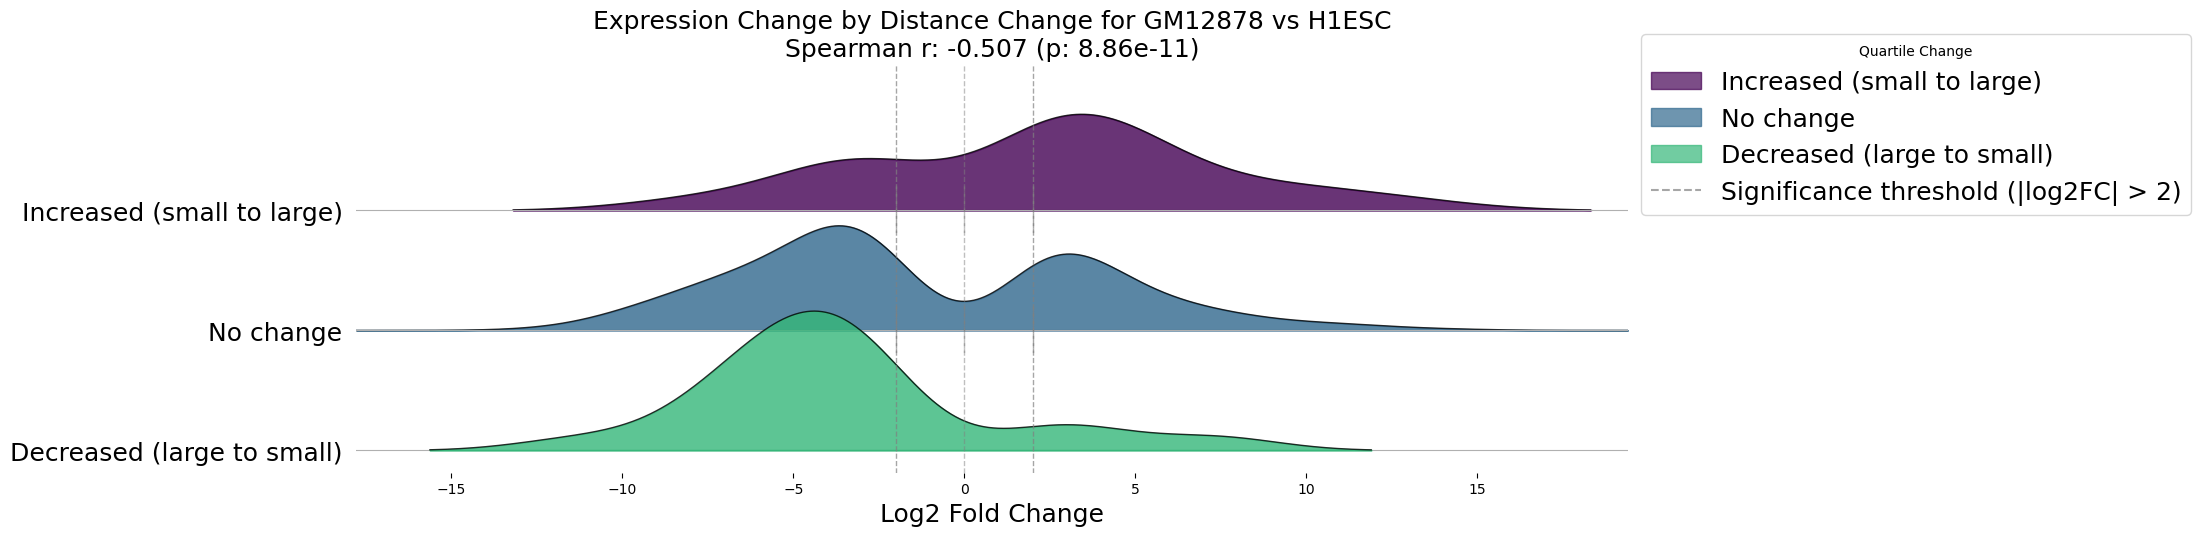

In [149]:
# Example usage
fig, corr_data = plot_distance_vs_expression_correlation(
    gm12878_gene_to_closest_avg_enhancer_all,
    h1esc_gene_to_closest_avg_enhancer_all,
    gm12878_vs_h1esc_results_df,
    "GM12878",
    "H1ESC",
    figsize=(15, 5),
    plot_path="figs/exp4_gm_h1_joy.png"
)
plt.show()

Spearman r: -0.550, p-value: 6.69e-13


/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log2

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_14059/1618299180.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



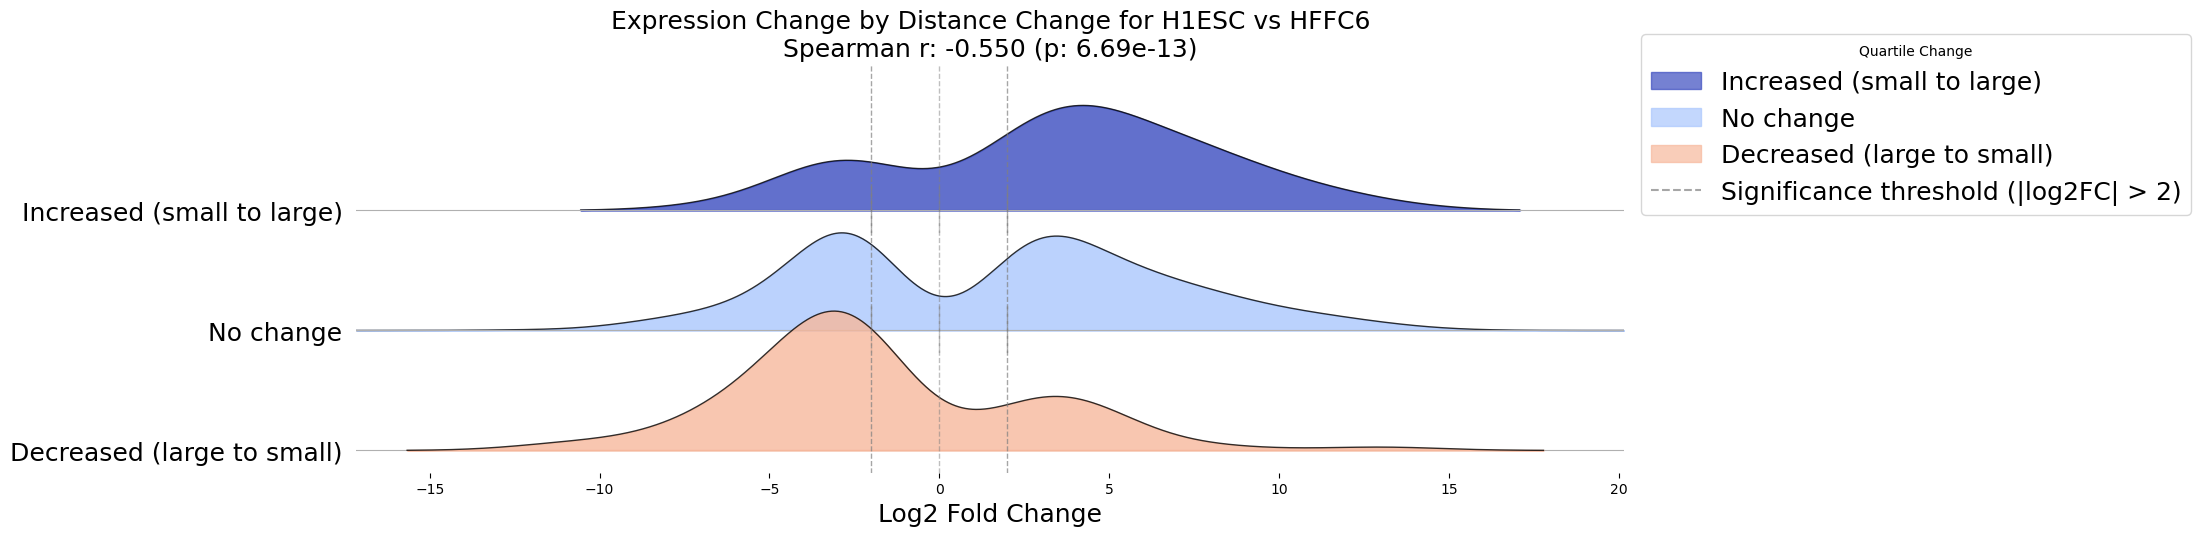

In [150]:
fig, corr_data = plot_distance_vs_expression_correlation(
    h1esc_gene_to_closest_avg_enhancer_all,
    hffc6_gene_to_closest_avg_enhancer_all,
    h1esc_vs_hffc6_results_df,
    "H1ESC",
    "HFFC6",
    figsize=(15, 5),
    plot_path="figs/exp4_h1_hffc_joy.png",
    color_map=cm.coolwarm
)

plt.show()

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log2

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_14059/1618299180.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Spearman r: -0.644, p-value: 5.36e-16


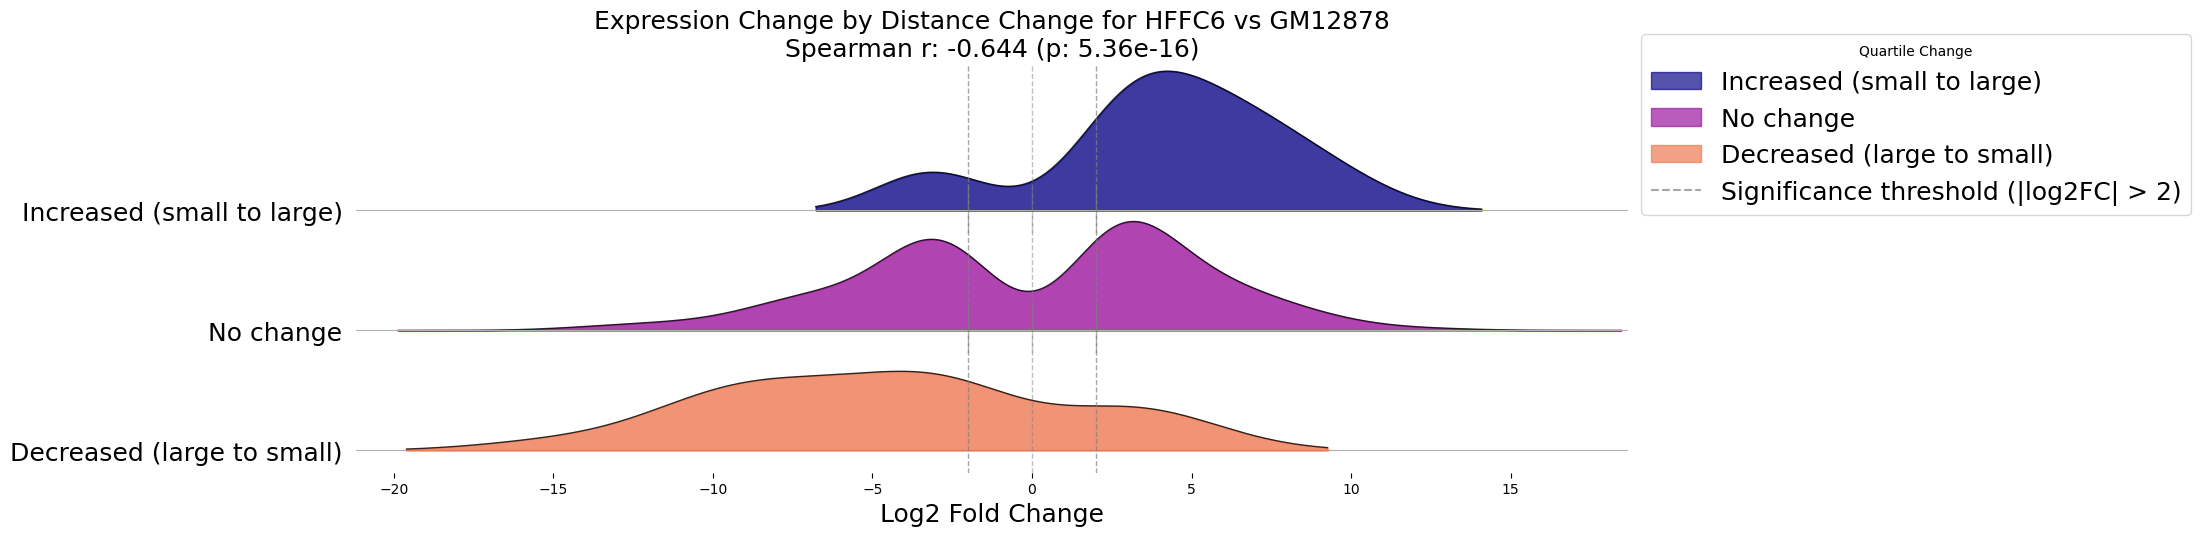

In [151]:
fig, corr_data = plot_distance_vs_expression_correlation(
    hffc6_gene_to_closest_avg_enhancer_all,
    gm12878_gene_to_closest_avg_enhancer_all,
    hffc6_vs_gm12878_results_df,
    "HFFC6",
    "GM12878",
    figsize=(15, 5),
    plot_path="figs/exp4_hffc_gm_joy.png",
    color_map=cm.plasma
)

plt.show()